In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from fmnist_dataset import Fashion_MNIST
from mnist import MNIST
import numpy as np

Using TensorFlow backend.


In [2]:
def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [3]:
limit_mem() #***:一定要有这行，不然就会报错。

In [4]:
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
fmnist = Fashion_MNIST()

In [5]:
data_dir="../data"
data = MNIST(data_dir, return_type="lists")
x_train,y_train = data.load_training()
x_train = np.asarray(x_train).reshape((-1, 28, 28, 1))
y_train = np.asarray(y_train)
x_test,y_test = data.load_testing()
x_test = np.asarray(x_test).reshape((-1, 28, 28, 1))
y_test = np.asarray(y_test)

In [6]:
val_size = 5000
x_val,y_val = x_train[-val_size:],y_train[-val_size:]
x_train,y_train = x_train[:-val_size],y_train[:-val_size]

In [7]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test /255

In [8]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)
y_val = to_categorical(y_val,10)

In [9]:
model_path = '../model/naive_model.h5'
from keras.models import load_model
import os
if not os.path.exists(model_path):
    input_shape = (img_rows, img_cols, 1)
    model = Sequential()
    model.add(Conv2D(32,
                     activation='relu',
                     input_shape=input_shape,
                     nb_row=3,
                     nb_col=3))
    model.add(Conv2D(64, activation='relu',
                     nb_row=3,
                     nb_col=3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.metrics.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_val, y_val))
    # import matplotlib.pyplot as plt
    # %matplotlib inline
    # # summarize history for accuracy
    # plt.plot(model.history['acc'])
    # plt.plot(model.history['val_acc'])
    # plt.title('model accuracy')
    # plt.ylabel('accuracy')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    # # summarize history for loss
    # plt.plot(model.history['loss'])
    # plt.plot(model.history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    model.save(model_path)
else:
    model = load_model(model_path)

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22198901411890984
Test accuracy: 0.9194


In [11]:
num_test = x_test.shape[0]
mask = np.random.choice(num_test,2000)
x_test_batch = x_test[mask]
y_test_batch = y_test[mask]
score = model.evaluate(x_test_batch, y_test_batch, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22083431255817412
Test accuracy: 0.918


In [12]:
predictions = model.predict(x_test_batch)
idx = 0
cnt = 0
x_pred_true = []
y_pred_true = []
while cnt < 1000:
    if np.argmax(predictions[idx]) == np.argmax(y_test_batch[idx]):
        x_pred_true.append(x_test_batch[idx])
        y_pred_true.append(y_test_batch[idx])
        cnt += 1
    idx += 1

In [13]:
x_pred_true = np.asarray(x_pred_true)
y_pred_true = np.asarray(y_pred_true)

plot...


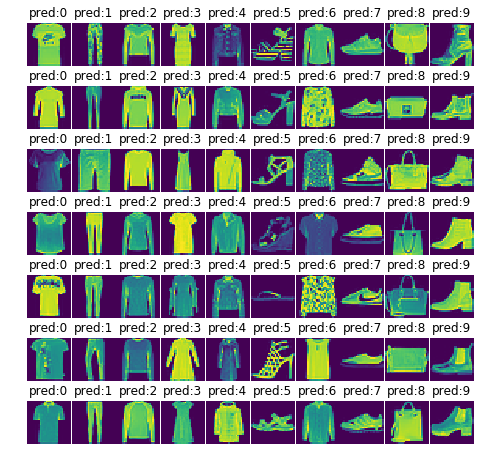

In [14]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
print('plot...')
samples_per_class = 7
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(7, 10)
gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
classes = range(10)
for y_, cls in enumerate(classes):
    idxs = np.flatnonzero(y_ == np.argmax(y_pred_true, axis=1))#1代表行
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#随机抽7张该类图片
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_ 
        ax = plt.subplot(gs[plt_idx])
        ax.axis('off')
        plt.imshow(x_pred_true[idx].reshape((28, 28)))
        pred = np.argmax(y_pred_true[idx])
        plt.title('pred:' + str(pred))
plt.show()

In [15]:
import keras.backend as K
import tensorflow as tf
from tensorflow import float32
from keras import metrics

In [48]:
class Transformer():
    def __init__(self,model):
        old = range(10)
        new = list(range(1,10))
        new.append(0)
        self.old2new = dict(zip(old,new))
        self.model = model
        self.alpha = 0.01 #学习率
    def gen_adv(self,x,label,iterations = 50):
        x = np.reshape(x,(-1,28,28,1))
#         print(x.shape)
        label = np.argmax(label)
        target= self.old2new[label]
#         print(target)
        target = to_categorical(target,10,dtype='float32')
#         print(target)
        for _ in range(iterations):
#             print(type(x))
            x = self.one_iter(x,target)
        x_adv = x
        return x_adv
    def one_iter(self,x,target):
#         print(x.shape)
        target_variable = K.variable(target)
#         print(model.output)
#         print(target_variable)
        loss = -1*metrics.categorical_crossentropy(self.model.output,target_variable)
        gradients = K.gradients(loss,model.input)
        get_grad_values = K.function([model.input],gradients)
        grad_values = get_grad_values([x])[0]
        delta = K.sign(grad_values) 
        x_adv = x - self.alpha * delta
        sess = K.get_session()
        x_adv_val = sess.run(x_adv,feed_dict={model.input:x})
        x_adv_val = np.clip(x_adv_val, 0., 1.)
        return x_adv_val

In [49]:
transformer = Transformer(model)

In [50]:
new_image = transformer.gen_adv(x_pred_true[0],y_pred_true[0],50)

In [51]:
pred = model.predict(np.array([new_image[0],]))
pred = pred[0]
prob = np.exp(pred) / np.sum(np.exp(pred))
print(prob)
print(prob.argmax())

[0.23194897 0.08533803 0.08533803 0.08533812 0.08533803 0.08533803
 0.0853467  0.08533803 0.08533804 0.08533803]
0


In [53]:
pred = model.predict(np.array([x_pred_true[0],]))
pred = pred[0]
prob = np.exp(pred) / np.sum(np.exp(pred))
print(prob)
print(prob.argmax())

[0.08602235 0.0859518  0.08576723 0.22720729 0.08617046 0.08565658
 0.08572944 0.085672   0.08608102 0.08574179]
3


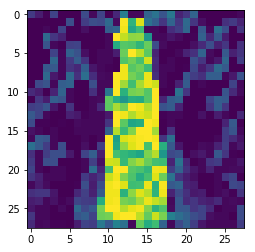

In [54]:
plt.imshow(new_image.reshape((28, 28)))

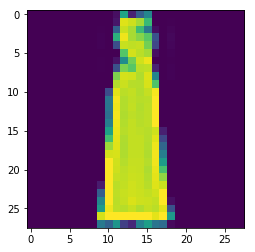

In [55]:
plt.imshow(x_pred_true[0].reshape((28, 28)))

In [56]:
def test_idx(idx,iterations = 2):
    transformer = Transformer(model)
    new_image = transformer.gen_adv(x_pred_true[idx],y_pred_true[idx],iterations)
    pred = model.predict(np.array([new_image[0],])) #0是因为new_image多了1维
    pred = pred[0]
    prob = np.exp(pred) / np.sum(np.exp(pred))
    print(prob)
    print(prob.argmax())
    pred = model.predict(np.array([x_pred_true[idx],]))
    pred = pred[0]
    prob = np.exp(pred) / np.sum(np.exp(pred))
    print(prob)
    print(prob.argmax())
    print('plot...')
    plt.figure(figsize=(9,9))
    plt.subplot(2, 1, 1)
    plt.imshow(new_image.reshape((28, 28)))   
    plt.title('new image')

    plt.subplot(2, 1, 2)
    plt.title('original image')
    plt.imshow(x_pred_true[idx].reshape((28, 28)))
#     plt.gcf().set_size_inches(15, 12)
    plt.show()

[0.08533915 0.23196335 0.08533712 0.08533712 0.08533712 0.08533712
 0.08533723 0.08533712 0.08533756 0.08533712]
1
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


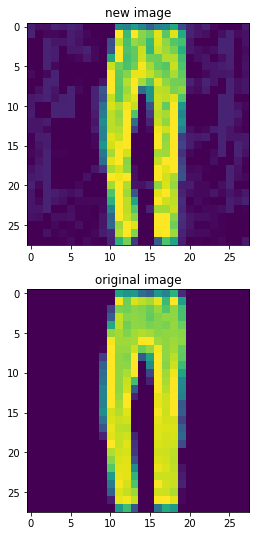

In [57]:
test_idx(1,10)

[0.08552704 0.23020212 0.08544783 0.08544786 0.08544783 0.08544785
 0.08545275 0.08544791 0.08613097 0.08544783]
1
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


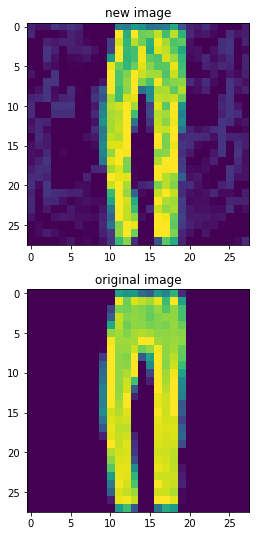

In [58]:
test_idx(1,15)

[0.08534057 0.23195069 0.08533792 0.08533792 0.08533792 0.08533792
 0.08533809 0.08533792 0.08534313 0.08533792]
1
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


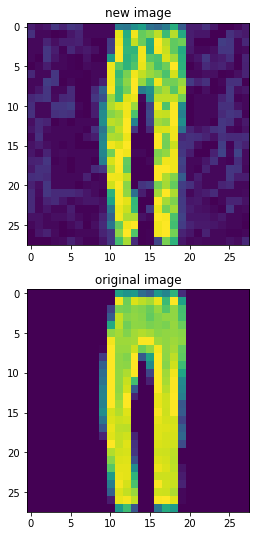

In [59]:
test_idx(1,20)

[0.08874486 0.13107872 0.08839807 0.08839808 0.08839807 0.0883981
 0.08842968 0.08839825 0.16135815 0.08839807]
8
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


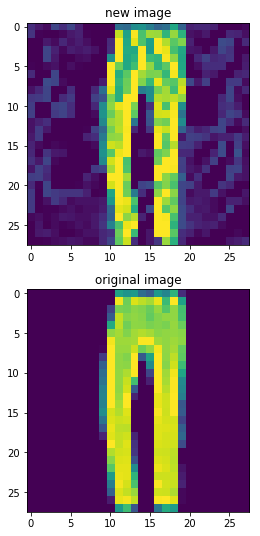

In [60]:
test_idx(1,25)

[0.08723125 0.20197348 0.08701906 0.08701908 0.08701906 0.08701907
 0.08703716 0.08701921 0.10164357 0.08701906]
1
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


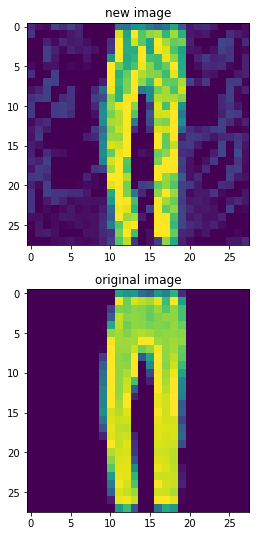

In [61]:
test_idx(1,23)

[0.08842394 0.17611116 0.08804701 0.08804703 0.08804701 0.08804703
 0.08807733 0.08804721 0.11910523 0.08804701]
1
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


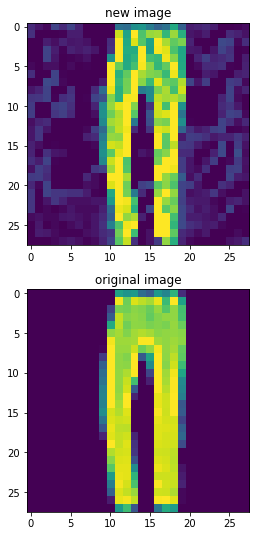

In [62]:
test_idx(1,24)

[0.08533677 0.08533679 0.08533676 0.08533676 0.08533676 0.08533676
 0.08533677 0.08533676 0.23196916 0.08533676]
8
[0.08533688 0.23196888 0.08533677 0.08533677 0.08533677 0.08533677
 0.0853368  0.08533677 0.08533677 0.08533677]
1
plot...


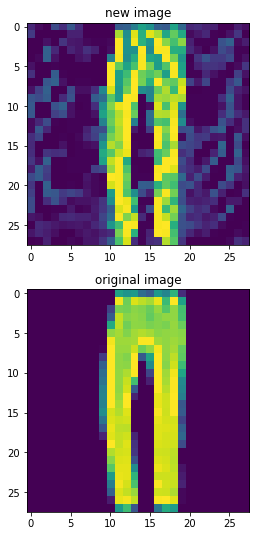

In [63]:
test_idx(1,35)

In [40]:
old = range(10)
new = list(range(1,10))
new.append(0)
old2new = dict(zip(old,new))
old2new

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

In [64]:
#调参数比较困难，迭代少，不起作用；迭代多，识别成非target类。
#算法应该没问题，可能是keras求梯度编程实现这块有问题。(应该是求梯度有问题)

[*] White box attack!


Using TensorFlow backend.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[*] Model built!
INFO:tensorflow:Restoring parameters from ../model/naive_model.ckpt
[*] Model loaded!
[*] Model parameters:
    fmnist_cnn/Variable:0 (5, 5, 1, 24)
    fmnist_cnn/Variable_1:0 (24,)
    fmnist_cnn/Variable_2:0 (4, 4, 24, 48)
    fmnist_cnn/Variable_3:0 (48,)
    fmnist_cnn/Variable_4:0 (3, 3, 48, 64)
    fmnist_cnn/Variable_5:0 (64,)
    fmnist_cnn/W4:0 (1600, 128)
    fmnist_cnn/Variable_6:0 (128,)
    fmnist_cnn/W5:0 (128, 10)
    fmnist_cnn/Variable_7:0 (10,)
[*] Model parameter size: 0.2413M
[*] Accuracy on test set: 0.85710
plot...


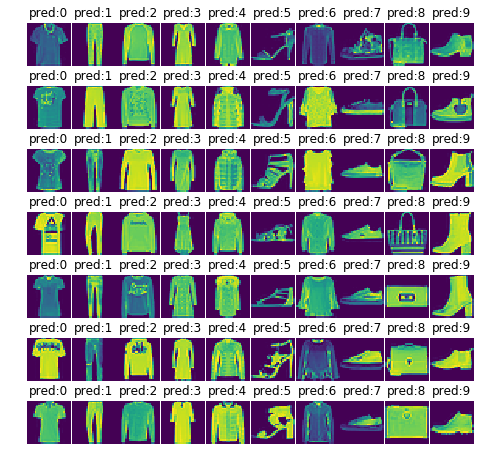

In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import pickle
import os, sys
from fmnist_dataset import Fashion_MNIST
from cnn import CNN
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline

def plot_attack_image(x_pred_true, y_pred_true):
    print('plot...')
    samples_per_class = 7
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(7, 10)
    gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
    classes = range(10)
    num_classes = 10
    for y_, cls in enumerate(classes):
        idxs = np.flatnonzero(y_ == np.argmax(y_pred_true, axis=1))  # 1代表行
        idxs = np.random.choice(idxs, samples_per_class, replace=False)  # 随机抽7张该类图片
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y_
            ax = plt.subplot(gs[plt_idx])
            ax.axis('off')
            plt.imshow(x_pred_true[idx].reshape((28, 28)))
            pred = np.argmax(y_pred_true[idx])
            plt.title('pred:' + str(pred))
    plt.show()



print("[*] White box attack!", flush=True)
# Load dataset
d = Fashion_MNIST()
# Read hyper-parameters
n_correct = 1000
model_path = '../model/naive_model.ckpt'
dtype = np.float32
# Build model
with tf.variable_scope("fmnist_cnn") as vs:
    m = CNN(scope_name="fmnist_cnn", is_inference=True)
    print("[*] Model built!")
config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
m.restore(sess, model_path)
print("[*] Model loaded!")
print("[*] Model parameters:")
parm_cnt = 0
variable = [v for v in tf.trainable_variables()]
for v in variable:
    print("   ", v.name, v.get_shape())
    parm_cnt_v = 1
    for i in v.get_shape().as_list():
        parm_cnt_v *= i
    parm_cnt += parm_cnt_v
print("[*] Model parameter size: %.4fM" % (parm_cnt / 1024 / 1024))

d.test.reset_epoch()

acc = 0
correct_image = []
correct_label = []
for _iter in range(d.test.size):
    x, y = d.test.next_batch(1, dtype=dtype)
    x = x / 255
    # 如果训练的时候除以了255，那么测试的时候也要做。
    y_hat = m.infer_op(sess, x)
    if (np.argmax(y_hat) == np.argmax(y[0])):
        correct_image.append(x[0])
        correct_label.append(y[0])
        acc += 1
acc /= d.test.size
print("[*] Accuracy on test set: %.5f" % (acc))

_correct_image = []
_correct_label = []

_idx = random.sample(range(len(correct_image)), n_correct)
for i in _idx:
    _correct_image.append(correct_image[i])
    _correct_label.append(correct_label[i])

_correct_image = np.array(_correct_image)
_correct_label = np.array(_correct_label)

x_attack = _correct_image
y_attack = _correct_label

plot_attack_image(x_attack, y_attack)



# 注意，助教给的测试接口有问题，可能会重复采样。



In [2]:
for _iter in range(d.test.size):
    x, y = d.test.next_batch(1, dtype=dtype)
    x = x / 255
    # 如果训练的时候除以了255，那么测试的时候也要做。
    y_hat = m.infer_op(sess, x)
    print(y_hat)
    if (np.argmax(y_hat) == np.argmax(y[0])):
        correct_image.append(x[0])
        correct_label.append(y[0])
        acc += 1
    break
acc /= d.test.size

[array([[1.8036382e-01, 4.2798566e-03, 5.1555526e-04, 7.5108957e-01,
        7.0613093e-04, 1.3101074e-07, 6.2498167e-02, 2.2294668e-09,
        5.4678135e-04, 4.4922368e-09]], dtype=float32)]


In [3]:
x.shape

(1, 28, 28, 1)

In [4]:
y_hat

[array([[1.8036382e-01, 4.2798566e-03, 5.1555526e-04, 7.5108957e-01,
         7.0613093e-04, 1.3101074e-07, 6.2498167e-02, 2.2294668e-09,
         5.4678135e-04, 4.4922368e-09]], dtype=float32)]

In [5]:
np.argmax(y_hat)

3

In [6]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
y_attack[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [8]:
m.infer_op(sess,np.expand_dims(x_attack[0], 0))

[array([[2.6989531e-09, 7.3980727e-10, 5.4458842e-12, 6.4958472e-10,
         1.5938582e-12, 6.1493106e-03, 2.0760383e-11, 6.2003750e-02,
         3.2564503e-07, 9.3184662e-01]], dtype=float32)]

In [9]:
m.infer_op(sess,np.expand_dims(x_attack[0], 0))[0].argmax()

9

In [ ]:
#这个预测的样本怎么会被挑选进来？可能是助教的代码有问题？  最后重启jupyter kernel就没问题了。

In [10]:
y_attack[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [11]:
print('the number of images is',len(x_attack))
for i in range(len(x_attack)):
    if np.argmax(y_attack[i]) != m.infer_op(sess,np.expand_dims(x_attack[i], 0))[0].argmax():
        print('wrong!')
        print(i)

the number of images is 1000


In [116]:
class Attacker(object):
    def __init__(self, model):
        self.model = model
        old = range(10)
        new = list(range(1, 10))
        new.append(0)
        self.old2new = dict(zip(old, new))
        self.alpha = 0.01  # 学习率

    def gen_adv(self, x, label, sess,iterations=10):
        old_image = x.copy()
        x = np.reshape(x, (-1, 28, 28, 1))
        #         print(x.shape)
#         print('label',label)
        label = np.argmax(label)
#         print(label)
        target = self.old2new[label]
        #         print(target)
        target = to_categorical(target, 10, dtype='float32')
#         print(target)
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess, x, np.expand_dims(target, 0))
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
#             print(grad_val.shape)
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
        x_adv = x
        print('orginal label',label)
        pred = self.model.infer_op(sess,np.expand_dims(old_image, 0))
        pred = pred[0]
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_ori = prob[0]
#         print(prob)
        
        pred = self.model.infer_op(sess,x_adv)
        pred = np.array(pred)
#         print(pred.shape)
        pred = pred[0]
#         print(pred.shape)
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_new = prob[0]
        pred = np.argmax(pred,1)[0]
        print('now prediction is',pred)
        
#         print(prob)
        print('        before   after')
        for i in range(len(prob_ori)):
            print('class {}: {:.2f} \t {:.2f}'.format(i,float(prob_ori[i]),float(prob_new[i])))
        if self.old2new[label] == pred:
            print('attack succeed')
        else:
            print('attack fail')

        print('plot...')
        plt.figure(figsize=(9, 9))
        plt.subplot(2, 1, 1)
        plt.imshow(x_adv[0].reshape((28, 28)))
        plt.title('new image')

        plt.subplot(2, 1, 2)
        plt.title('original image')
        plt.imshow(old_image.reshape((28, 28)))
        #     plt.gcf().set_size_inches(15, 12)
        plt.show()

        return x_adv
    
    def get_targets(self,labels):
        targets = []
        for label in labels: 
            label = np.argmax(label)
            target = self.old2new[label]
            targets.append(target)
        targets = to_categorical(targets, 10, dtype='float32')
        return targets
        
    def gen_advs(self,X,Y,sess,iterations = 50):
        X = np.array(X)
        X = np.reshape(X, (-1, 28, 28, 1))
        targets = self.get_targets(Y)
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess,X,targets)
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
#             print(grad_val.shape)
            X -= self.alpha * np.sign(grad_val)
            X = np.clip(X, 0., 1.)
        X_adv = X
        pred = self.model.infer_op(sess,X_adv)
        pred = pred[0]
        test_size = pred.shape[0]
#         print(pred)
        cnt = 0
        for i in range(test_size):
            if np.argmax(pred[i]) == np.argmax(targets[i]):
                cnt += 1
        acc = cnt / test_size
        print('attack success rate:',acc)
    def gen_advs_and_plot(self,X,Y,sess,iterations = 50):
        ori_images = X.copy()
        X = np.array(X)
        X = np.reshape(X, (-1, 28, 28, 1))
        targets = self.get_targets(Y)
        acc_history = []
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess,X,targets)
            grad_val = np.array(grad_val)
    #             print(grad_val.shape)
            grad_val = grad_val[0][0]
    #             print(grad_val.shape)
            X -= self.alpha * np.sign(grad_val)
            X = np.clip(X, 0., 1.)
            pred = self.model.infer_op(sess,X)
            pred = pred[0]
            test_size = pred.shape[0]
            cnt = 0
            for i in range(test_size):
                if np.argmax(pred[i]) == np.argmax(targets[i]):
                    cnt += 1
            acc = cnt / test_size
            acc_history.append(acc)
        plt.plot(acc_history,'b')
        plt.plot(acc_history,'bo')    
        plt.xlabel('Iteration')
        plt.ylabel('Attack success rate')
        plt.gcf().set_size_inches(15, 12)
        plt.show()
        print('final attack success rate:',acc_history[-1])
        samples = []
        for i in range(test_size):
            if np.argmax(pred[i]) == np.argmax(targets[i]):
                samples.append((ori_images[i],X[i],np.argmax(targets[i])))
        idxs = np.random.choice(len(samples),10,replace=False)
        selected_samples = []
        for idx in idxs:
            selected_samples.append(samples[idx])
        return selected_samples
    def plot_samples(self,samples):
        row_n = len(samples)
        fig = plt.figure(figsize=(16,16))
        gs = gridspec.GridSpec(7, 10)
        gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
        col_n = 2
        for idx,sample in enumerate(samples):
            plt_idx = col_n*idx
            ax = plt.subplot(gs[plt_idx])
            ax.axis('off')
            plt.imshow(sample[0].reshape(28,28))
            plt_idx = col_n*idx+1
            ax = plt.subplot(gs[plt_idx])
            plt.imshow(sample[1].reshape(28,28))
            ax.axis('off')
            plt.title('class:' + str(int(sample[2])))
#             print('class :',sample[2])
        plt.show()

In [117]:
attacker = Attacker(m)

orginal label 9
now prediction is 0
        before   after
class 0: 0.20 	 0.22
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.10 	 0.09
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


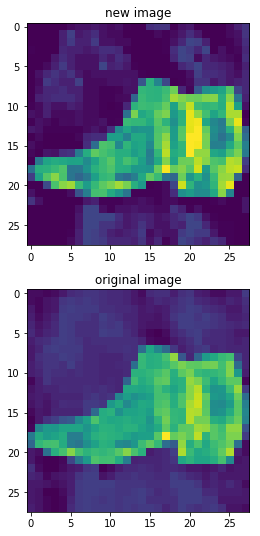

In [57]:
new_image = attacker.gen_adv(x_attack[0],y_attack[0],sess)

orginal label 4
now prediction is 4
        before   after
class 0: 0.09 	 0.09
class 1: 0.09 	 0.09
class 2: 0.09 	 0.12
class 3: 0.09 	 0.09
class 4: 0.22 	 0.14
class 5: 0.09 	 0.09
class 6: 0.09 	 0.10
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack fail
plot...


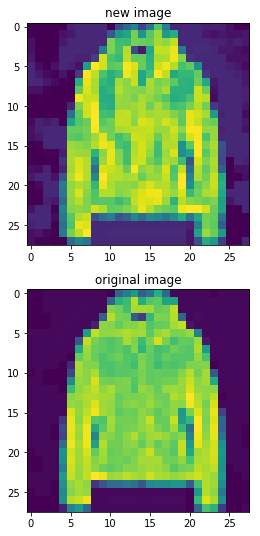

In [23]:
new_image = attacker.gen_adv(x_attack[1],y_attack[1],sess)

orginal label 0
now prediction is 0
        before   after
class 0: 0.22 	 0.15
class 1: 0.09 	 0.11
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.09 	 0.11
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack fail
plot...


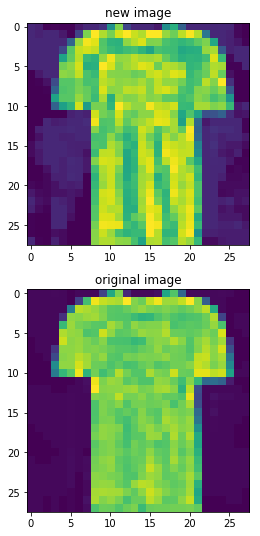

In [24]:
new_image = attacker.gen_adv(x_attack[2],y_attack[2],sess)

orginal label 5
now prediction is 6
        before   after
class 0: 0.09 	 0.09
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.23 	 0.09
class 6: 0.09 	 0.23
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


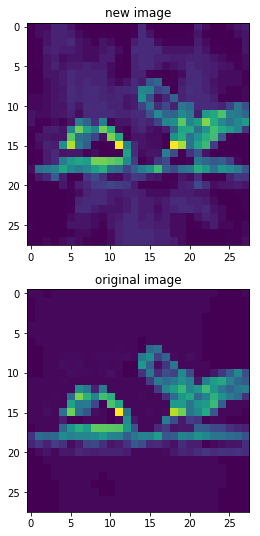

In [25]:
new_image = attacker.gen_adv(x_attack[3],y_attack[3],sess)

In [76]:
 attacker.gen_advs(x_attack[:3],y_attack[:3],sess,iterations = 10)

attack success rate: 0.6666666666666666


In [77]:
 attacker.gen_advs(x_attack[:3],y_attack[:3],sess,iterations = 20)

attack success rate: 1.0


In [78]:
print(y_attack[:2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [79]:
 attacker.gen_advs(x_attack,y_attack,sess,iterations = 10)

attack success rate: 0.57


In [80]:
 attacker.gen_advs(x_attack,y_attack,sess,iterations = 20)

attack success rate: 0.915


In [82]:
 attacker.gen_advs(x_attack,y_attack,sess,iterations = 30)

attack success rate: 0.984


In [81]:
 attacker.gen_advs(x_attack,y_attack,sess,iterations = 50)

attack success rate: 0.997


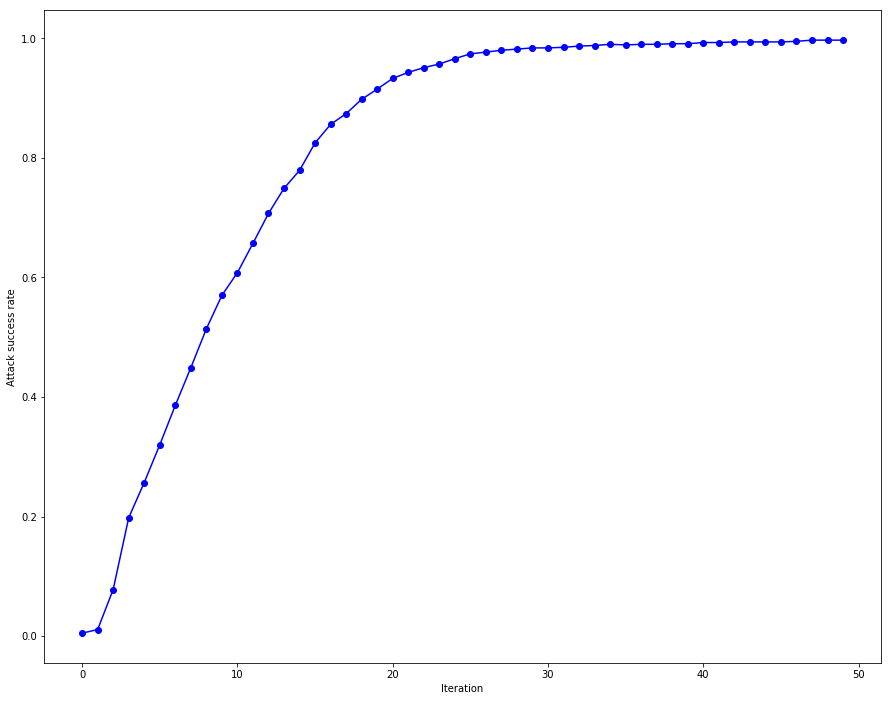

final attack success rate: 0.997


In [89]:
 attacker.gen_advs_and_plot(x_attack,y_attack,sess,iterations = 50)

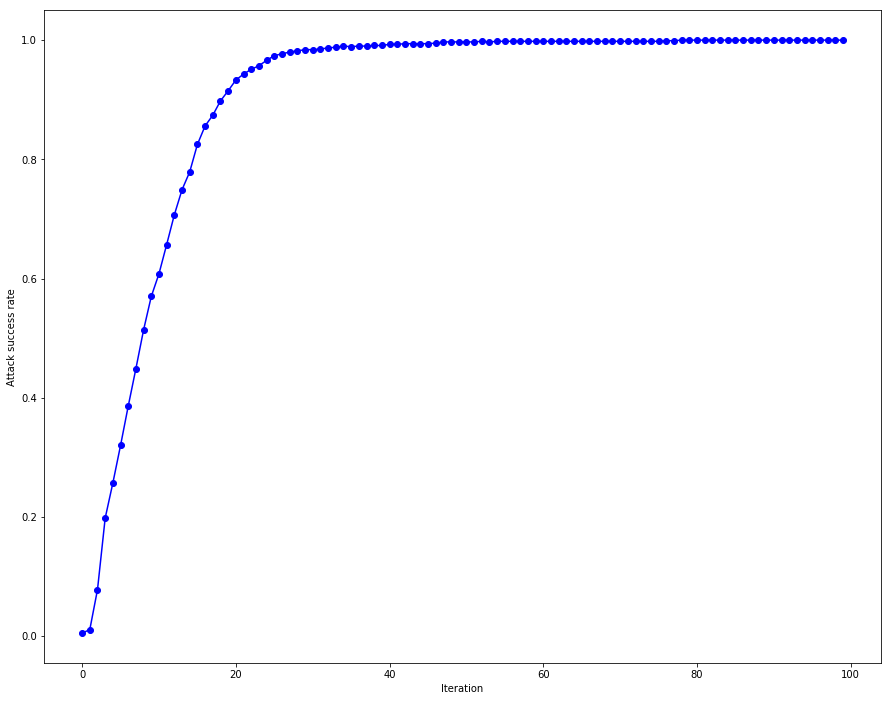

final attack success rate: 1.0


In [90]:
 attacker.gen_advs_and_plot(x_attack,y_attack,sess,iterations = 100)

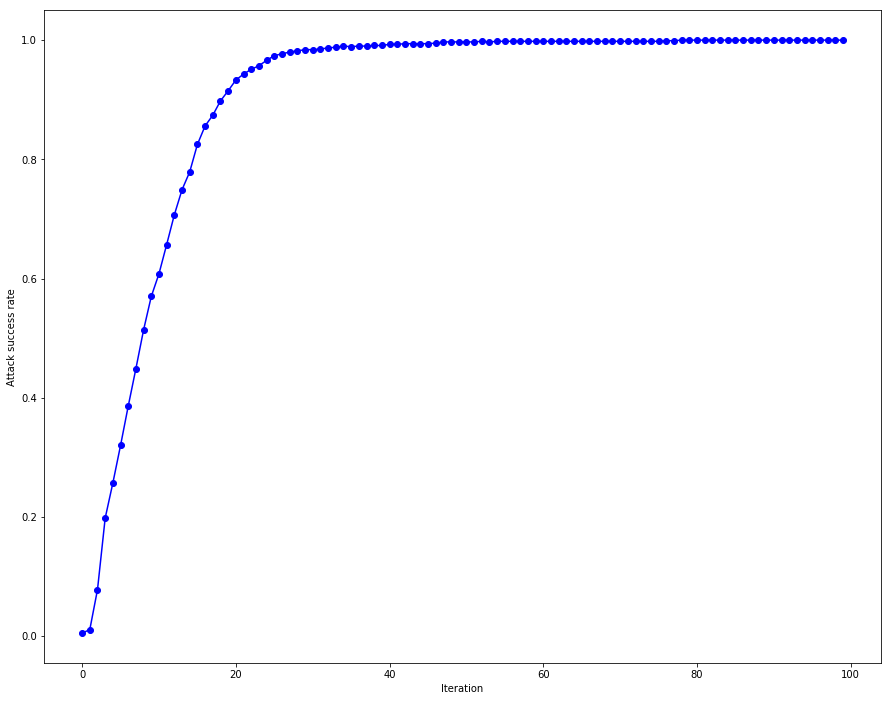

final attack success rate: 1.0


In [119]:
samples = attacker.gen_advs_and_plot(x_attack,y_attack,sess,iterations = 100)

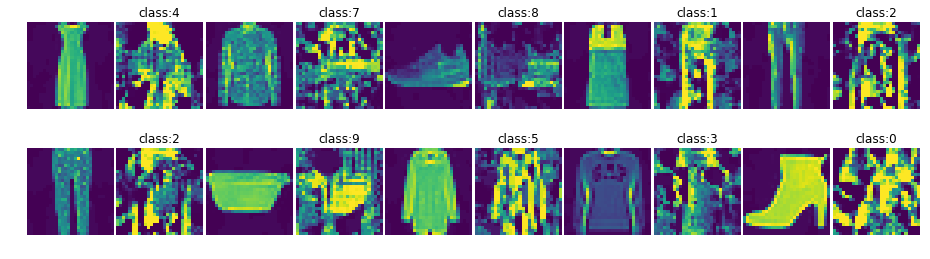

In [120]:
attacker.plot_samples(samples)

In [ ]:
#没有l2loss 迭代次数过多之后，扰动过大。

In [159]:
class Attacker(object):
    def __init__(self, model):
        self.model = model
        old = range(10)
        new = list(range(1, 10))
        new.append(0)
        self.old2new = dict(zip(old, new))
        self.alpha = 0.01  # 学习率
        self.old_images_ph = tf.placeholder(np.float32,[None,28,28,1])
        self.adv_images_ph = tf.placeholder(np.float32,[None,28,28,1])
        self.l2_grad = 2*(self.adv_images_ph-self.old_images_ph)

    def gen_adv(self, x, label, sess,iterations=10):
        old_image = x.copy()
        x = np.reshape(x, (-1, 28, 28, 1))
        #         print(x.shape)
#         print('label',label)
        label = np.argmax(label)
#         print(label)
        target = self.old2new[label]
        #         print(target)
        target = to_categorical(target, 10, dtype='float32')
#         print(target)
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess, x, np.expand_dims(target, 0))
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
#             print(grad_val.shape)
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
        x_adv = x
        print('orginal label',label)
        pred = self.model.infer_op(sess,np.expand_dims(old_image, 0))
        pred = pred[0]
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_ori = prob[0]
#         print(prob)
        
        pred = self.model.infer_op(sess,x_adv)
        pred = np.array(pred)
#         print(pred.shape)
        pred = pred[0]
#         print(pred.shape)
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_new = prob[0]
        pred = np.argmax(pred,1)[0]
        print('now prediction is',pred)
        
#         print(prob)
        print('        before   after')
        for i in range(len(prob_ori)):
            print('class {}: {:.2f} \t {:.2f}'.format(i,float(prob_ori[i]),float(prob_new[i])))
        if self.old2new[label] == pred:
            print('attack succeed')
        else:
            print('attack fail')

        print('plot...')
        plt.figure(figsize=(9, 9))
        plt.subplot(2, 1, 1)
        plt.imshow(x_adv[0].reshape((28, 28)))
        plt.title('new image')

        plt.subplot(2, 1, 2)
        plt.title('original image')
        plt.imshow(old_image.reshape((28, 28)))
        #     plt.gcf().set_size_inches(15, 12)
        plt.show()

        return x_adv
    
    def gen_adv_l2_spe(self, x, label, sess,iterations=10):
        old_image = x.copy()
        x = np.reshape(x, (-1, 28, 28, 1))
        label = np.argmax(label)
        target = self.old2new[label]
        target = to_categorical(target, 10, dtype='float32')
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess, x, np.expand_dims(target, 0))
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
            l2_grad_val = sess.run(self.l2_grad,feed_dict={self.old_images_ph:np.expand_dims(old_image,0),self.adv_images_ph:x})
#             print(grad_val.shape)
            grad_val += l2_grad_val
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
        x_adv = x
#         print('orginal label',label)
        pred = self.model.infer_op(sess,np.expand_dims(old_image, 0))
        pred = pred[0]
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_ori = prob[0]
#         print(prob)
        pred = self.model.infer_op(sess,x_adv)
        pred = np.array(pred)
#         print(pred.shape)
        pred = pred[0]
#         print(pred.shape)
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_new = prob[0]
        pred = np.argmax(pred,1)[0]
        flag = True
        if self.old2new[label] == pred:
#             print('attack succeed')
            pass
        else:
#             print('attack fail')
            flag = False
        return flag
    
    def gen_adv_l2(self, x, label, sess,iterations=10):
        old_image = x.copy()
        x = np.reshape(x, (-1, 28, 28, 1))
        #         print(x.shape)
#         print('label',label)
        label = np.argmax(label)
#         print(label)
        target = self.old2new[label]
        #         print(target)
        target = to_categorical(target, 10, dtype='float32')
#         print(target)
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess, x, np.expand_dims(target, 0))
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
            l2_grad_val = sess.run(self.l2_grad,feed_dict={self.old_images_ph:np.expand_dims(old_image,0),self.adv_images_ph:x})
#             print(grad_val.shape)
            grad_val += l2_grad_val
            x -= self.alpha * np.sign(grad_val)
            x = np.clip(x, 0., 1.)
        x_adv = x
        print('orginal label',label)
        pred = self.model.infer_op(sess,np.expand_dims(old_image, 0))
        pred = pred[0]
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_ori = prob[0]
#         print(prob)
        
        pred = self.model.infer_op(sess,x_adv)
        pred = np.array(pred)
#         print(pred.shape)
        pred = pred[0]
#         print(pred.shape)
        prob = np.exp(pred) / np.sum(np.exp(pred))
        prob_new = prob[0]
        pred = np.argmax(pred,1)[0]
        print('now prediction is',pred)
        
#         print(prob)
        print('        before   after')
        for i in range(len(prob_ori)):
            print('class {}: {:.2f} \t {:.2f}'.format(i,float(prob_ori[i]),float(prob_new[i])))
        if self.old2new[label] == pred:
            print('attack succeed')
        else:
            print('attack fail')
        print('plot...')
        plt.figure(figsize=(9, 9))
        plt.subplot(2, 1, 1)
        plt.imshow(x_adv[0].reshape((28, 28)))
        plt.title('new image')

        plt.subplot(2, 1, 2)
        plt.title('original image')
        plt.imshow(old_image.reshape((28, 28)))
        #     plt.gcf().set_size_inches(15, 12)
        plt.show()

        return x_adv
    
    
    def get_targets(self,labels):
        targets = []
        for label in labels: 
            label = np.argmax(label)
            target = self.old2new[label]
            targets.append(target)
        targets = to_categorical(targets, 10, dtype='float32')
        return targets
        
    def gen_advs(self,X,Y,sess,iterations = 50):
        X = np.array(X)
        X = np.reshape(X, (-1, 28, 28, 1))
        targets = self.get_targets(Y)
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess,X,targets)
            grad_val = np.array(grad_val)
#             print(grad_val.shape)
            grad_val = grad_val[0][0]
#             print(grad_val.shape)
            X -= self.alpha * np.sign(grad_val)
            X = np.clip(X, 0., 1.)
        X_adv = X
        pred = self.model.infer_op(sess,X_adv)
        pred = pred[0]
        test_size = pred.shape[0]
#         print(pred)
        cnt = 0
        for i in range(test_size):
            if np.argmax(pred[i]) == np.argmax(targets[i]):
                cnt += 1
        acc = cnt / test_size
        print('attack success rate:',acc)
    def gen_advs_and_plot(self,X,Y,sess,iterations = 50):
        ori_images = X.copy()
        X = np.array(X)
        X = np.reshape(X, (-1, 28, 28, 1))
        targets = self.get_targets(Y)
        acc_history = []
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess,X,targets)
            grad_val = np.array(grad_val)
    #             print(grad_val.shape)
            grad_val = grad_val[0][0]
    #             print(grad_val.shape)
            X -= self.alpha * np.sign(grad_val)
            X = np.clip(X, 0., 1.)
            pred = self.model.infer_op(sess,X)
            pred = pred[0]
            test_size = pred.shape[0]
            cnt = 0
            for i in range(test_size):
                if np.argmax(pred[i]) == np.argmax(targets[i]):
                    cnt += 1
            acc = cnt / test_size
            acc_history.append(acc)
        plt.plot(acc_history,'b')
        plt.plot(acc_history,'bo')    
        plt.xlabel('Iteration')
        plt.ylabel('Attack success rate')
        plt.gcf().set_size_inches(15, 12)
        plt.show()
        print('final attack success rate:',acc_history[-1])
        samples = []
        for i in range(test_size):
            if np.argmax(pred[i]) == np.argmax(targets[i]):
                samples.append((ori_images[i],X[i],np.argmax(targets[i])))
        idxs = np.random.choice(len(samples),10,replace=False)
        selected_samples = []
        for idx in idxs:
            selected_samples.append(samples[idx])
        return selected_samples
    
    def gen_advs_l2_spe(self,X,Y,sess,iterations = 50):
        cnt = 0
        for i in range(X.shape[0]):
            flag = self.gen_adv_l2_spe(X[i],Y[i],sess,iterations)
            if flag:
                cnt += 1
        print('attack success rate:',cnt/X.shape[0])
        
        
    def gen_advs_l2_and_plot(self,X,Y,sess,iterations = 50):
        ori_images = X.copy()
        X = np.array(X)
        X = np.reshape(X, (-1, 28, 28, 1))
        targets = self.get_targets(Y)
        acc_history = []
        for _ in range(iterations):
            grad_val = self.model.grad_op(sess,X,targets)
            grad_val = np.array(grad_val)
    #             print(grad_val.shape)
            grad_val = grad_val[0][0]
#             print(grad_val.shape)
            l2_grad_val = sess.run(self.l2_grad,feed_dict={self.old_images_ph:ori_images,self.adv_images_ph:X})
#             print(l2_grad_val.shape)
            grad_val += 0.1 * l2_grad_val #不加0.1波动太大。
            X -= self.alpha * np.sign(grad_val)
            X = np.clip(X, 0., 1.)
            pred = self.model.infer_op(sess,X)
            pred = pred[0]
            test_size = pred.shape[0]
            cnt = 0
            for i in range(test_size):
                if np.argmax(pred[i]) == np.argmax(targets[i]):
                    cnt += 1
            acc = cnt / test_size
            acc_history.append(acc)
        plt.plot(acc_history,'b')
        plt.plot(acc_history,'bo')    
        plt.xlabel('Iteration')
        plt.ylabel('Attack success rate')
        plt.gcf().set_size_inches(15, 12)
        plt.show()
        print('final attack success rate:',acc_history[-1])
        samples = []
        for i in range(test_size):
            if np.argmax(pred[i]) == np.argmax(targets[i]):
                samples.append((ori_images[i],X[i],np.argmax(targets[i])))
        idxs = np.random.choice(len(samples),10,replace=False)
        selected_samples = []
        for idx in idxs:
            selected_samples.append(samples[idx])
        return selected_samples
    
    
    def plot_samples(self,samples):
        row_n = len(samples)
        fig = plt.figure(figsize=(16,16))
        gs = gridspec.GridSpec(7, 10)
        gs.update(wspace=0.035, hspace=0.1)  # set the spacing between axes.
        col_n = 2
        for idx,sample in enumerate(samples):
            plt_idx = col_n*idx
            ax = plt.subplot(gs[plt_idx])
            ax.axis('off')
            plt.imshow(sample[0].reshape(28,28))
            plt_idx = col_n*idx+1
            ax = plt.subplot(gs[plt_idx])
            plt.imshow(sample[1].reshape(28,28))
            ax.axis('off')
            plt.title('class:' + str(int(sample[2])))
#             print('class :',sample[2])
        plt.show()

In [160]:
attacker2 = Attacker(m)

orginal label 9
now prediction is 0
        before   after
class 0: 0.22 	 0.20
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.09 	 0.10
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


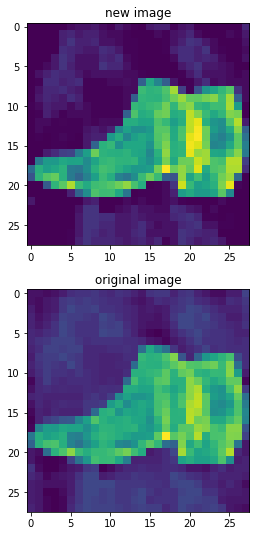

In [128]:
_ = attacker2.gen_adv_l2(x_attack[0],y_attack[0],sess,10)

orginal label 9
now prediction is 0
        before   after
class 0: 0.22 	 0.17
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.09 	 0.09
class 6: 0.09 	 0.09
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.11
attack succeed
plot...


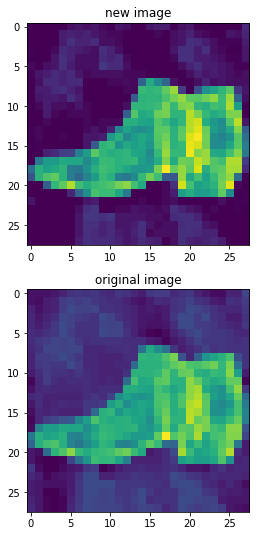

In [129]:
_ = attacker2.gen_adv_l2(x_attack[0],y_attack[0],sess,50)

orginal label 4
now prediction is 2
        before   after
class 0: 0.09 	 0.09
class 1: 0.09 	 0.09
class 2: 0.10 	 0.12
class 3: 0.09 	 0.09
class 4: 0.21 	 0.11
class 5: 0.09 	 0.10
class 6: 0.09 	 0.10
class 7: 0.09 	 0.09
class 8: 0.09 	 0.10
class 9: 0.09 	 0.11
attack fail
plot...


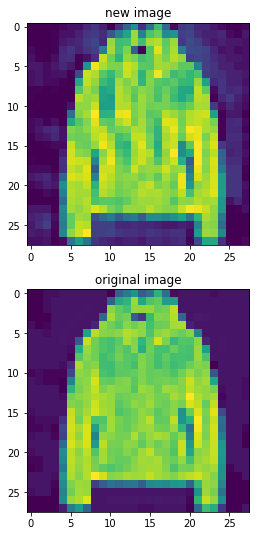

In [134]:
_ = attacker2.gen_adv_l2(x_attack[1],y_attack[1],sess,50)

orginal label 5
now prediction is 6
        before   after
class 0: 0.09 	 0.09
class 1: 0.09 	 0.09
class 2: 0.09 	 0.09
class 3: 0.09 	 0.09
class 4: 0.09 	 0.09
class 5: 0.20 	 0.09
class 6: 0.09 	 0.20
class 7: 0.09 	 0.09
class 8: 0.10 	 0.09
class 9: 0.09 	 0.09
attack succeed
plot...


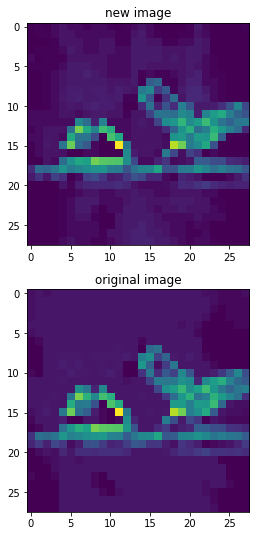

In [135]:
_ = attacker2.gen_adv_l2(x_attack[3],y_attack[3],sess,50)

orginal label 2
now prediction is 2
        before   after
class 0: 0.09 	 0.09
class 1: 0.09 	 0.09
class 2: 0.18 	 0.14
class 3: 0.09 	 0.10
class 4: 0.09 	 0.10
class 5: 0.09 	 0.09
class 6: 0.11 	 0.12
class 7: 0.09 	 0.09
class 8: 0.09 	 0.09
class 9: 0.09 	 0.09
attack fail
plot...


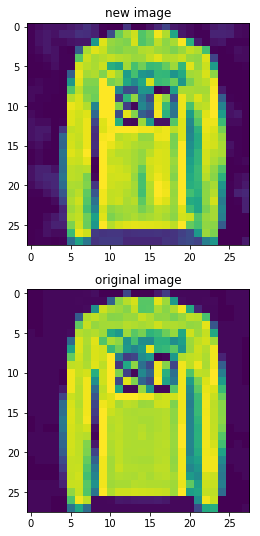

In [141]:
_ = attacker2.gen_adv_l2(x_attack[4],y_attack[4],sess,50)

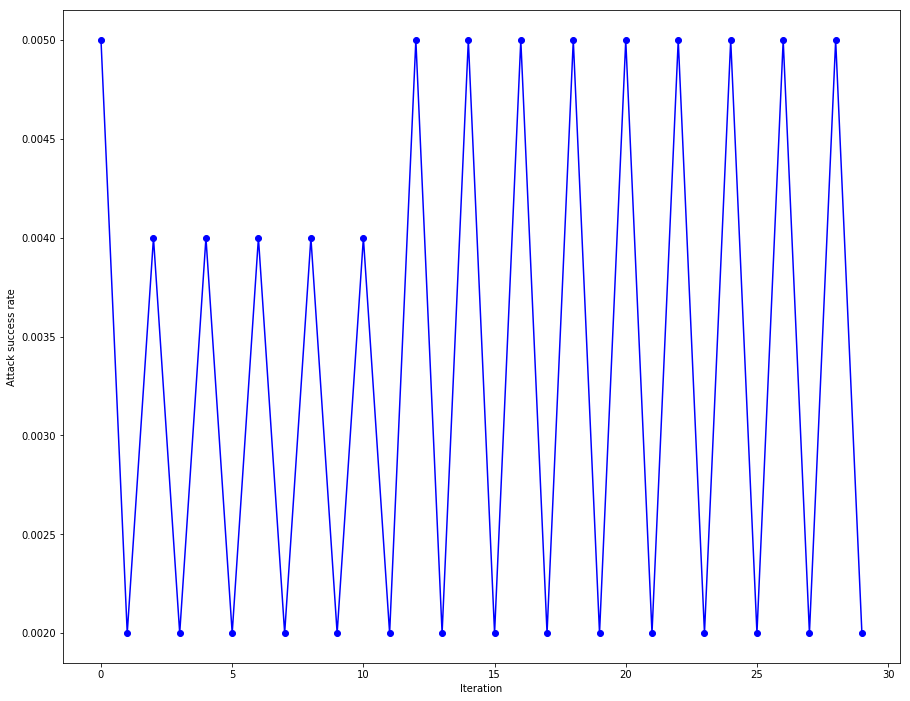

final attack success rate: 0.002


ValueError: Cannot take a larger sample than population when 'replace=False'

In [146]:
samples = attacker2.gen_advs_l2_and_plot(x_attack,y_attack,sess,30)

In [161]:
attacker2.gen_advs_l2_spe(x_attack,y_attack,sess,10)

attack success rate: 0.403


In [162]:
attacker2.gen_advs_l2_spe(x_attack,y_attack,sess,50)

attack success rate: 0.568


加了l2loss，batch计算，算梯度就有问题；单个样本计算，就没问题。应该是实现上的问题。
加了l2loss，确实不好训练了，50次迭代，成功率仅有0.568

In [163]:
_

array([[[[0.01      ],
         [0.03      ],
         [0.05      ],
         [0.05      ],
         [0.05      ],
         [0.06999999],
         [0.08999999],
         [0.13784313],
         [0.08960783],
         [0.01      ],
         [0.        ],
         [0.        ],
         [0.1496078 ],
         [0.        ],
         [0.        ],
         [0.04      ],
         [0.10490195],
         [0.20294121],
         [0.06999999],
         [0.05      ],
         [0.03      ],
         [0.01      ],
         [0.03      ],
         [0.06999999],
         [0.08999999],
         [0.07999999],
         [0.03      ],
         [0.02      ]],

        [[0.01      ],
         [0.05      ],
         [0.06999999],
         [0.05      ],
         [0.08999999],
         [0.08999999],
         [0.13784313],
         [0.12999998],
         [0.08999999],
         [0.01      ],
         [0.2315687 ],
         [0.76921576],
         [0.859804  ],
         [0.9229412 ],
         [0.7268628 ],
         

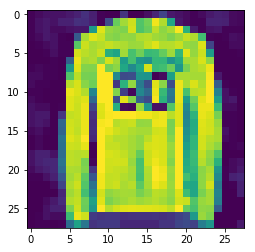

In [165]:
plt.imshow(_.reshape(28,28))

In [166]:
plt.imsave("buf.png",_.reshape(28,28))